# Treatments and Spillovers
Julian Hsu

2025 Sept 13


The purpose of this script is to visually show how different degrees of spillover effects would bias down any treatment effects as we study the treatment over time.

Post:

Visually show your spillover effect by plotting your treatment and control over time. 
Spillovers are a common threat in getting an accurate read from your experiment, and cause you to mis-estimate the financial benefits of your treatment. When we roll out a new feature to the "Treatment" group, we often assume the "Control" group remains pure, living in a pristine, untreated universe. This is rarely the case.

There are many examples, from social networks to marketplaces. We can plot the spillover effects by looking at outcome of treatment and control over time, as shown here (https://github.com/shoepaladin/causalinference_crashcourse/blob/4a488ec02ab94816d30447b21256892719856135/OtherMaterial/Experimental%20Analysis%20and%20Deep%20Diving%20Treatment%20Effects/Spillovers%20in%20Treatments%20Trends.ipynb). The observed difference between treatment and control narrows as the treatment "spills over" into the control group, making the intervention seem less effective than it truly is. As spillover strength increases, the treatment and control trends converge more quickly, biasing the final estimate toward zero.

Of course, in reality things are rarely so clean and easy to show. Causal methods such as difference-in-difference and synthetic control can remove noise and make this easier to plot. However, they are not sure things either. How have you demonstrated spillover effects in your work?

#CausalInference #DataScience #Experimentation #A/BTesting 


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [33]:
# Parameters
n_periods_pre = 10
n_periods_rollout = 20
n_periods_total = n_periods_pre + n_periods_rollout
base_control = 100
treatment_effect = 10 # The true causal effect we want to measure

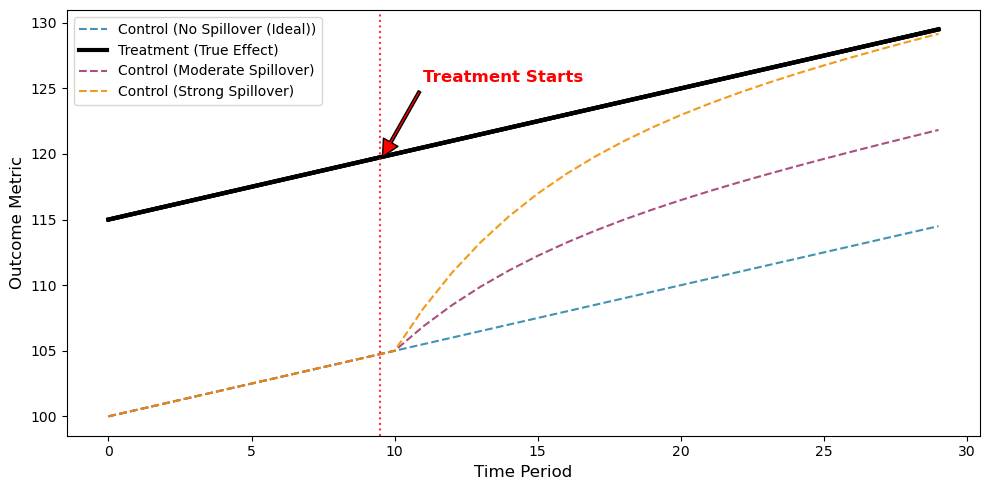

In [55]:

# Generate time array
time = np.arange(n_periods_total)
# Create a DataFrame
df = pd.DataFrame({'time': time})
# 1. Define the true underlying trend (common to both groups)
df['base_trend'] = 0.5 * df['time']
# 2. Create Group Dummy: 0 = Control, 1 = Treatment
df['group'] = 0 # Control by default
# Simulate the staggered rollout: treatment group starts at period 10
df.loc[df['time'] >= n_periods_pre, 'group'] = 1
# 3. Define the true potential outcomes WITHOUT any spillover
df['control_true'] = base_control + df['base_trend']
df['treatment_true'] = base_control + df['base_trend'] + treatment_effect
# 4. Simulate different levels of spillover# Spillover effect: a fraction of the treatment effect leaks to control
# We'll model it as a function of time since treatment started

spillover_strengths = [0.0, 0.5, 1] 
labels = ['No Spillover (Ideal)', 'Moderate Spillover', 'Strong Spillover']
colors = ['#2E86AB', '#A23B72', '#F18F01']

# Create the figure
fig, ax = plt.subplots(figsize=(10, 5))
for i, (strength, label, color) in enumerate(zip(spillover_strengths, labels, colors)):
    # Calculate time since treatment for the spillover effect    
    # Spillover starts the period AFTER treatment begins and increases over time    
    df['time_since_treat'] = (df['time'] - n_periods_pre).clip(lower=0)
    # The spillover effect grows as the rollout progresses    
    df['spillover_effect'] = strength * treatment_effect * (1 - np.exp(-df['time_since_treat'] / 5))
    # Apply the spillover to the control group's observed outcome    
    df['control_observed'] = df['control_true'] + df['spillover_effect']
    # The treatment group's outcome is just the true outcome    
    df['treatment_observed'] = df['treatment_true']
    # Plot the observed outcomes for each group    
    # Control Group    
    ax.plot(df['time'], df['control_observed'], color=color, linestyle='--', label=f'Control ({label})', alpha=0.9)
    # Treatment Group (same for all scenarios, so we plot it once)    
    if i == 0: 
        # Only add the treatment label once to avoid legend duplication        
        ax.plot(df['time'], df['treatment_observed'], color='black', linestyle='-', linewidth=3, label='Treatment (True Effect)')
    else:
        ax.plot(df['time'], df['treatment_observed'], color='black', linestyle='-', linewidth=3)
    # Add a vertical line to indicate the start of the treatment rollout
ax.axvline(x=n_periods_pre - 0.5, color='red', linestyle=':', alpha=0.8)
# Add aesthetics and labels
ax.set_xlabel('Time Period', fontsize=12)
ax.set_ylabel('Outcome Metric', fontsize=12)
ax.legend(loc='upper left', frameon=True)

ax.annotate('Treatment Starts',
            xy=(n_periods_pre - 0.5, df['treatment_observed'].max()-10),
            xytext=(n_periods_pre + 1, df['treatment_observed'].max() + 6-10),
            arrowprops=dict(facecolor='red', shrink=0.05, width=2),
            fontsize=12,
            color='red',
            fontweight='bold')

plt.tight_layout()
plt.show()

